In [1]:
# Cell 0 — setup & imports 

# basic helpers
import os                       # work with files and folders
from pathlib import Path        # easier path handling
import re                       # regular expressions for cleaning text

# data + math
import pandas as pd             # load and work with tables (dataframes)
import numpy as np              # arrays and math helpers

# plotting
import matplotlib.pyplot as plt # plot graphs
import seaborn as sns           # nicer plots
sns.set(style="whitegrid")     # use a clean plot style

# machine learning helpers
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack   # to combine sparse (tfidf) + dense (numeric)

# models and metrics
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, roc_curve

# saving/loading models
import joblib  # save models to disk

# show current folder so you know where notebook runs
print("Current working directory:", os.getcwd())
print("Setup complete — imports done.")


Current working directory: D:\Sem5\INT395_SUPERVISED LEARNING\safe-text-monitor\notebooks
Setup complete — imports done.


In [2]:
# Cell 1 — Load Kaggle train.csv into a dataframe

from pathlib import Path
import pandas as pd

# Correct relative path: go UP one folder, then into data/raw
raw_path = Path("../data/raw/train.csv")

# Debug info
print("Notebook working directory:", Path.cwd())
print("Looking for file at:", raw_path.resolve())

# Check if file exists
if not raw_path.exists():
    raise FileNotFoundError("❌ train.csv not found! Check the path above.")

# Load CSV
df = pd.read_csv(raw_path, low_memory=False)

print("✔ File loaded successfully!")
df.head()



Notebook working directory: D:\Sem5\INT395_SUPERVISED LEARNING\safe-text-monitor\notebooks
Looking for file at: D:\Sem5\INT395_SUPERVISED LEARNING\safe-text-monitor\data\raw\train.csv
✔ File loaded successfully!


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
# --- Cell 2: BASIC DATA INSPECTION ---

print("Shape of dataset (rows, columns):", df.shape)

print("\nFirst 5 rows:")
display(df.head())

print("\nColumn names:")
print(df.columns.tolist())

print("\nDataset Info:")
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())


Shape of dataset (rows, columns): (159571, 8)

First 5 rows:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0



Column names:
['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB

Missing values per column:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [4]:
# Cell 3 — Create single-label classification target and a numeric threat_score

from pathlib import Path
OUT_DIR = Path("../data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# start from df loaded in Cell 1
df_clean = df.copy()   # work on a copy so original remains safe

# remove exact duplicate rows based on comment_text
before = len(df_clean)
df_clean.drop_duplicates(subset=["comment_text"], inplace=True)
print("Duplicates removed:", before - len(df_clean))

# remove blank or whitespace-only comments
before = len(df_clean)
df_clean = df_clean[df_clean["comment_text"].astype(str).str.strip().str.len() > 0].reset_index(drop=True)
print("Empty/blank rows removed:", before - len(df_clean))

# create label_class: priority order -> threat > severe_toxic > toxic > obscene > insult > identity_hate > Normal
def single_label(row):
    if int(row["threat"]) == 1:
        return "Threat"
    if int(row["severe_toxic"]) == 1:
        return "SevereToxic"
    if int(row["toxic"]) == 1:
        return "Toxic"
    if int(row["obscene"]) == 1:
        return "Obscene"
    if int(row["insult"]) == 1:
        return "Insult"
    if int(row["identity_hate"]) == 1:
        return "Hate"
    return "Normal"

df_clean["label_class"] = df_clean.apply(single_label, axis=1)

# create a numeric threat_score (0-100) using a simple weighted sum (you can change weights)
df_clean["threat_score"] = (
    df_clean["threat"] * 100 +
    df_clean["severe_toxic"] * 80 +
    df_clean["identity_hate"] * 70 +
    df_clean["toxic"] * 50 +
    df_clean["insult"] * 40 +
    df_clean["obscene"] * 30
).astype(float)

# check results
print("Rows after cleaning:", len(df_clean))
print("Label class counts:")
print(df_clean["label_class"].value_counts())
# save intermediate cleaned file
df_clean.to_csv(OUT_DIR / "df_clean.csv", index=False)
print("Saved cleaned CSV to:", (OUT_DIR / "df_clean.csv").resolve())
display(df_clean.head())


Duplicates removed: 0
Empty/blank rows removed: 0
Rows after cleaning: 159571
Label class counts:
label_class
Normal         143346
Toxic           13362
SevereToxic      1483
Obscene           519
Threat            478
Insult            329
Hate               54
Name: count, dtype: int64
Saved cleaned CSV to: D:\Sem5\INT395_SUPERVISED LEARNING\safe-text-monitor\data\processed\df_clean.csv


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_class,threat_score
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,Normal,0.0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,Normal,0.0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,Normal,0.0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,Normal,0.0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,Normal,0.0


In [5]:
# Cell 4 — Clean text for modelling, preserving Devanagari (Hindi) characters

import re

def clean_text_keep_hindi(s):
    if not isinstance(s, str):
        return ""
    s = s.lower()
    # remove URLs
    s = re.sub(r'http\S+|www\S+', ' ', s)
    # remove mentions and hashtags
    s = re.sub(r'@\w+|#\w+', ' ', s)
    # keep latin letters, digits, whitespace and Devanagari range \u0900-\u097F (Hindi)
    s = re.sub(r'[^a-z0-9\s\u0900-\u097F]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# create new cleaned text column
df_clean["text_clean"] = df_clean["comment_text"].apply(clean_text_keep_hindi)

# remove rows that became empty after cleaning
before = len(df_clean)
df_clean = df_clean[df_clean["text_clean"].str.strip() != ""].reset_index(drop=True)
print("Rows removed because text became empty after cleaning:", before - len(df_clean))

# save cleaned text file
df_clean.to_csv(OUT_DIR / "df_clean_text.csv", index=False)
print("Saved cleaned text CSV to:", (OUT_DIR / "df_clean_text.csv").resolve())
display(df_clean[["comment_text","text_clean","label_class","threat_score"]].head())


Rows removed because text became empty after cleaning: 13
Saved cleaned text CSV to: D:\Sem5\INT395_SUPERVISED LEARNING\safe-text-monitor\data\processed\df_clean_text.csv


,comment_text,text_clean,label_class,threat_score
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...,Normal,0.0
1,D'aww! He matches this background colour I'm s...,d aww he matches this background colour i m se...,Normal,0.0
2,"Hey man, I'm really not trying to edit war. It...",hey man i m really not trying to edit war it s...,Normal,0.0
3,"""\nMore\nI can't make any real suggestions on ...",more i can t make any real suggestions on impr...,Normal,0.0
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...,Normal,0.0


In [6]:
# Cell 5 — Create a few numeric features from the text that help the model

df_clean["text_len"] = df_clean["text_clean"].str.len()                     # characters
df_clean["word_count"] = df_clean["text_clean"].str.split().apply(lambda x: len(x))  # words
df_clean["exclamation_count"] = df_clean["text_clean"].str.count('!')
df_clean["question_count"] = df_clean["text_clean"].str.count(r'\?')
# original raw text may contain urls; has_url based on original comment_text
df_clean["has_url"] = df_clean["comment_text"].str.contains(r'http|www').fillna(False).astype(int)
# uppercase word ratio (on original text) — may be low for most cases, but keep it
df_clean["upper_ratio"] = df_clean["comment_text"].apply(lambda s: sum(1 for w in str(s).split() if w.isupper())/max(1,len(str(s).split())))

# quick peek
display(df_clean[["text_clean","text_len","word_count","exclamation_count","has_url","upper_ratio"]].head())
# save features
df_clean.to_csv(OUT_DIR / "df_features.csv", index=False)
print("Saved features CSV to:", (OUT_DIR / "df_features.csv").resolve())


,text_clean,text_len,word_count,exclamation_count,has_url,upper_ratio
0,explanation why the edits made under my userna...,261,50,0,0,0.046512
1,d aww he matches this background colour i m se...,102,20,0,0,0.058824
2,hey man i m really not trying to edit war it s...,229,44,0,0,0.000000
3,more i can t make any real suggestions on impr...,591,115,0,0,0.044248
4,you sir are my hero any chance you remember wh...,63,14,0,0,0.000000


Saved features CSV to: D:\Sem5\INT395_SUPERVISED LEARNING\safe-text-monitor\data\processed\df_features.csv


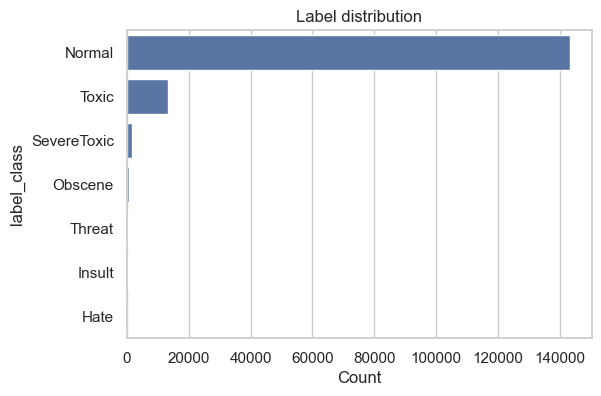

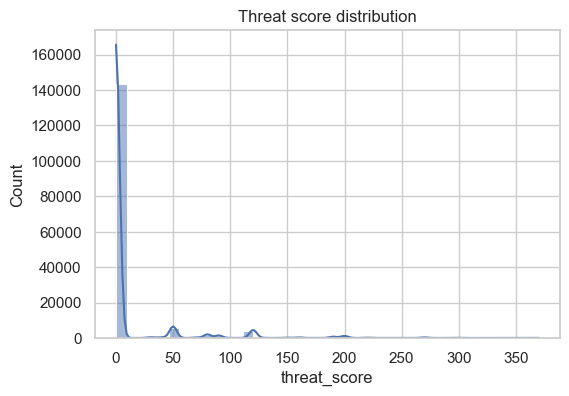

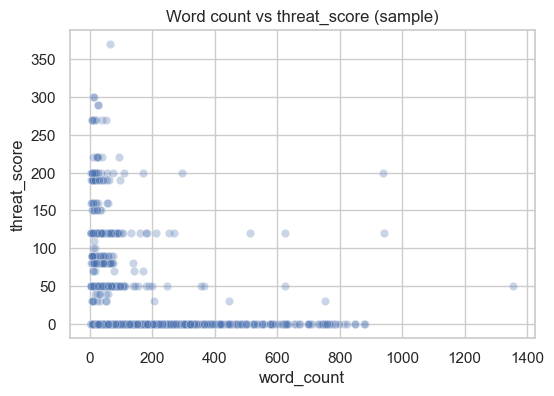

In [7]:
# Cell 6 — EDA: at least three analyses

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# 1) Class balance
plt.figure(figsize=(6,4))
sns.countplot(y="label_class", data=df_clean, order=df_clean["label_class"].value_counts().index)
plt.title("Label distribution")
plt.xlabel("Count")
plt.show()

# 2) threat_score distribution
plt.figure(figsize=(6,4))
sns.histplot(df_clean["threat_score"], bins=40, kde=True)
plt.title("Threat score distribution")
plt.show()

# 3) word_count vs threat_score (sample for speed)
plt.figure(figsize=(6,4))
sample = df_clean.sample(n=min(5000, len(df_clean)), random_state=42)
sns.scatterplot(x="word_count", y="threat_score", data=sample, alpha=0.3)
plt.title("Word count vs threat_score (sample)")
plt.show()


In [8]:
# Cell 7 — choose features (X) and targets (y)

# classification target (single label)
y_class = df_clean["label_class"]

# regression target
y_reg = df_clean["threat_score"]

# text input (we will TF-IDF this)
X_text = df_clean["text_clean"]

# numeric engineered features
num_features = ["text_len","word_count","exclamation_count","question_count","has_url","upper_ratio"]
X_num = df_clean[num_features].fillna(0)

print("Rows:", len(df_clean))
print("Text shape:", X_text.shape, "Numeric shape:", X_num.shape)


Rows: 159558
Text shape: (159558,) Numeric shape: (159558, 6)


In [9]:
# Cell 8 — split data into train and test sets (same split used for both tasks)

from sklearn.model_selection import train_test_split

X_train_text, X_test_text, X_train_num, X_test_num, y_train_class, y_test_class = train_test_split(
    X_text, X_num, y_class, test_size=0.20, random_state=42, stratify=y_class)

# align regression targets using the same indices
y_train_reg = df_clean.loc[X_train_text.index, "threat_score"]
y_test_reg  = df_clean.loc[X_test_text.index, "threat_score"]

print("Train rows:", len(X_train_text), "Test rows:", len(X_test_text))


Train rows: 127646 Test rows: 31912


In [10]:
# Cell 9 — Convert text to TF-IDF features, scale numeric, and combine

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

# TF-IDF: change max_features to smaller number to speed up if needed
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_tr_tfidf = tfidf.fit_transform(X_train_text)   # learn vocab on train
X_te_tfidf = tfidf.transform(X_test_text)        # use same vocab for test

# scale numeric features
scaler = StandardScaler()
X_tr_num_s = scaler.fit_transform(X_train_num)
X_te_num_s = scaler.transform(X_test_num)

# combine sparse tfidf + dense numeric (scipy sparse hstack)
X_train_final = hstack([X_tr_tfidf, X_tr_num_s])
X_test_final  = hstack([X_te_tfidf, X_te_num_s])

print("Final shapes -> train:", X_train_final.shape, " test:", X_test_final.shape)
# save transformers for later use
joblib.dump(tfidf, "../models/tfidf.pkl")
joblib.dump(scaler, "../models/scaler.pkl")
print("Saved TF-IDF and scaler to ../models/")


Final shapes -> train: (127646, 10006)  test: (31912, 10006)
Saved TF-IDF and scaler to ../models/


In [11]:
# Cell 10 — Train and evaluate at least 3 classification models

# Cell 10A — Logistic Regression (robust)
import time, os, joblib, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

os.makedirs("../models", exist_ok=True)

# Options: set SAMPLE_N to an int to train on a subset for speed, or None to use full train set
SAMPLE_N = None   # e.g. 50000 or None

# Sanity checks
if 'X_train_final' not in globals() or 'y_train_class' not in globals():
    raise NameError("X_train_final or y_train_class not found. Run feature-prep cells first.")
if 'X_test_final' not in globals() or 'y_test_class' not in globals():
    raise NameError("X_test_final or y_test_class not found. Run feature-prep / split cells first.")

# Prepare training data (safe sampling using numeric indices)
if SAMPLE_N is None:
    X_tr = X_train_final
    y_tr = y_train_class
else:
    n = X_train_final.shape[0]
    sample_n = min(SAMPLE_N, n)
    rng = np.random.default_rng(42)
    idx = rng.choice(n, size=sample_n, replace=False)
    X_tr = X_train_final[idx]
    try:
        y_tr = y_train_class.iloc[idx].values
    except Exception:
        y_tr = np.asarray(y_train_class)[idx]

print("Training Logistic Regression. SAMPLE_N =", SAMPLE_N)
log_model = LogisticRegression(max_iter=1200, class_weight="balanced", random_state=42)

t0 = time.time()
log_model.fit(X_tr, y_tr)
t1 = time.time()
print(f"Training done in {t1-t0:.1f} sec")

# evaluate
pred_train_lr = log_model.predict(X_tr)
pred_test_lr  = log_model.predict(X_test_final)
probs_test_lr = log_model.predict_proba(X_test_final) if hasattr(log_model, "predict_proba") else None

print("Train accuracy:", round(accuracy_score(y_tr, pred_train_lr), 4))
print("Test  accuracy:", round(accuracy_score(y_test_class, pred_test_lr), 4))
print("Test  weighted F1:", round(f1_score(y_test_class, pred_test_lr, average="weighted", zero_division=0), 4))
print("\nClassification report (TEST):")
print(classification_report(y_test_class, pred_test_lr, zero_division=0))

# save model and update clf_results
joblib.dump(log_model, "../models/logistic_baseline.pkl")
print("Saved logistic model to ../models/logistic_baseline.pkl")

# Update global clf_results
clf_results = globals().get("clf_results", {})
clf_results["Logistic"] = {"model": log_model, "pred_train": pred_train_lr, "pred_test": pred_test_lr, "probs_test": probs_test_lr}
globals()['clf_results'] = clf_results




Training Logistic Regression. SAMPLE_N = None
Training done in 91.1 sec
Train accuracy: 0.9068
Test  accuracy: 0.8814
Test  weighted F1: 0.9004

Classification report (TEST):
              precision    recall  f1-score   support

        Hate       0.00      0.00      0.00        11
      Insult       0.02      0.11      0.04        66
      Normal       0.98      0.91      0.95     28667
     Obscene       0.03      0.12      0.04       104
 SevereToxic       0.32      0.63      0.42       297
      Threat       0.30      0.62      0.41        95
       Toxic       0.45      0.63      0.53      2672

    accuracy                           0.88     31912
   macro avg       0.30      0.43      0.34     31912
weighted avg       0.93      0.88      0.90     31912

Saved logistic model to ../models/logistic_baseline.pkl


In [12]:
# Cell 10B — Random Forest (robust)
import time, os, joblib, numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

os.makedirs("../models", exist_ok=True)

# CONFIG: "fast" for quick, "full" for best-accuracy but slower
CONFIG = "fast"   # "fast" or "full"
SAMPLE_N = None   # int or None

if CONFIG == "full":
    n_estimators = 300
    max_depth = None
    n_jobs = -1
else:
    n_estimators = 100
    max_depth = 25
    n_jobs = -1

# prepare training data (safe sampling)
if SAMPLE_N is None:
    X_tr = X_train_final
    y_tr = y_train_class
else:
    n = X_train_final.shape[0]
    sample_n = min(SAMPLE_N, n)
    rng = np.random.default_rng(42)
    idx = rng.choice(n, size=sample_n, replace=False)
    X_tr = X_train_final[idx]
    try:
        y_tr = y_train_class.iloc[idx].values
    except Exception:
        y_tr = np.asarray(y_train_class)[idx]

print(f"Training RandomForest CONFIG={CONFIG} (n_estimators={n_estimators}, max_depth={max_depth}) on SAMPLE_N={SAMPLE_N}")
rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs, random_state=42, class_weight='balanced')

t0 = time.time()
rf_model.fit(X_tr, y_tr)
t1 = time.time()
print(f"Training done in {t1-t0:.1f} sec")

pred_train_rf = rf_model.predict(X_tr)
pred_test_rf  = rf_model.predict(X_test_final)
probs_test_rf = rf_model.predict_proba(X_test_final) if hasattr(rf_model, "predict_proba") else None

print("Train accuracy:", round(accuracy_score(y_tr, pred_train_rf), 4))
print("Test  accuracy:", round(accuracy_score(y_test_class, pred_test_rf), 4))
print("Test  weighted F1:", round(f1_score(y_test_class, pred_test_rf, average='weighted', zero_division=0), 4))
print("\nClassification report (TEST):")
print(classification_report(y_test_class, pred_test_rf, zero_division=0))

# save model
fname = f"rf_config_{CONFIG}.pkl"
joblib.dump(rf_model, f"../models/{fname}")
print("Saved RandomForest model to ../models/{}".format(fname))

# update clf_results
clf_results = globals().get("clf_results", {})
clf_results[f"RandomForest_{CONFIG}"] = {"model": rf_model, "pred_train": pred_train_rf, "pred_test": pred_test_rf, "probs_test": probs_test_rf}
globals()['clf_results'] = clf_results


Training RandomForest CONFIG=fast (n_estimators=100, max_depth=25) on SAMPLE_N=None
Training done in 35.3 sec
Train accuracy: 0.8336
Test  accuracy: 0.7922
Test  weighted F1: 0.8257

Classification report (TEST):
              precision    recall  f1-score   support

        Hate       0.00      0.00      0.00        11
      Insult       0.00      0.00      0.00        66
      Normal       0.95      0.85      0.89     28667
     Obscene       0.00      0.00      0.00       104
 SevereToxic       0.10      0.73      0.18       297
      Threat       0.12      0.51      0.19        95
       Toxic       0.20      0.28      0.23      2672

    accuracy                           0.79     31912
   macro avg       0.20      0.34      0.21     31912
weighted avg       0.87      0.79      0.83     31912

Saved RandomForest model to ../models/rf_config_fast.pkl


In [13]:
# Cell 10C — SVM (robust)
import time, os, joblib, numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

os.makedirs("../models", exist_ok=True)

MODE = "linear"   # "svc" (slower, probability=True) or "linear"
SAMPLE_N = None   # or an int like 30000

# prepare training data (safe sampling)
if SAMPLE_N is None:
    X_tr = X_train_final
    y_tr = y_train_class
else:
    n = X_train_final.shape[0]
    sample_n = min(SAMPLE_N, n)
    rng = np.random.default_rng(42)
    idx = rng.choice(n, size=sample_n, replace=False)
    X_tr = X_train_final[idx]
    try:
        y_tr = y_train_class.iloc[idx].values
    except Exception:
        y_tr = np.asarray(y_train_class)[idx]

if MODE == "svc":
    print("Training SVC(kernel='linear', probability=True) - SLOW")
    svm_model = SVC(kernel='linear', probability=True, random_state=42)
else:
    print("Training LinearSVC (fast; no predict_proba)")
    svm_model = LinearSVC(max_iter=5000, class_weight='balanced', random_state=42)

t0 = time.time()
svm_model.fit(X_tr, y_tr)
t1 = time.time()
print(f"Training done in {t1-t0:.1f} sec")

pred_train_svm = svm_model.predict(X_tr)
pred_test_svm  = svm_model.predict(X_test_final)
probs_test_svm = svm_model.predict_proba(X_test_final) if hasattr(svm_model, "predict_proba") else None

print("Train accuracy:", round(accuracy_score(y_tr, pred_train_svm), 4))
print("Test  accuracy:", round(accuracy_score(y_test_class, pred_test_svm), 4))
print("Test  weighted F1:", round(f1_score(y_test_class, pred_test_svm, average='weighted', zero_division=0), 4))
print("\nClassification report (TEST):")
print(classification_report(y_test_class, pred_test_svm, zero_division=0))

# save model
save_name = "svm_svc" if MODE=="svc" else "svm_linear"
joblib.dump(svm_model, f"../models/{save_name}.pkl")
print("Saved model to ../models/{}.pkl".format(save_name))

# update clf_results
clf_results = globals().get("clf_results", {})
clf_results[save_name] = {"model": svm_model, "pred_train": pred_train_svm, "pred_test": pred_test_svm, "probs_test": probs_test_svm}
globals()['clf_results'] = clf_results


Training LinearSVC (fast; no predict_proba)
Training done in 49.2 sec
Train accuracy: 0.9614
Test  accuracy: 0.9343
Test  weighted F1: 0.9337

Classification report (TEST):
              precision    recall  f1-score   support

        Hate       0.00      0.00      0.00        11
      Insult       0.02      0.02      0.02        66
      Normal       0.97      0.97      0.97     28667
     Obscene       0.05      0.03      0.04       104
 SevereToxic       0.32      0.33      0.33       297
      Threat       0.46      0.41      0.43        95
       Toxic       0.64      0.67      0.65      2672

    accuracy                           0.93     31912
   macro avg       0.35      0.35      0.35     31912
weighted avg       0.93      0.93      0.93     31912

Saved model to ../models/svm_linear.pkl


Model: Logistic
  Multiclass ROC-AUC (OVR): 0.8911


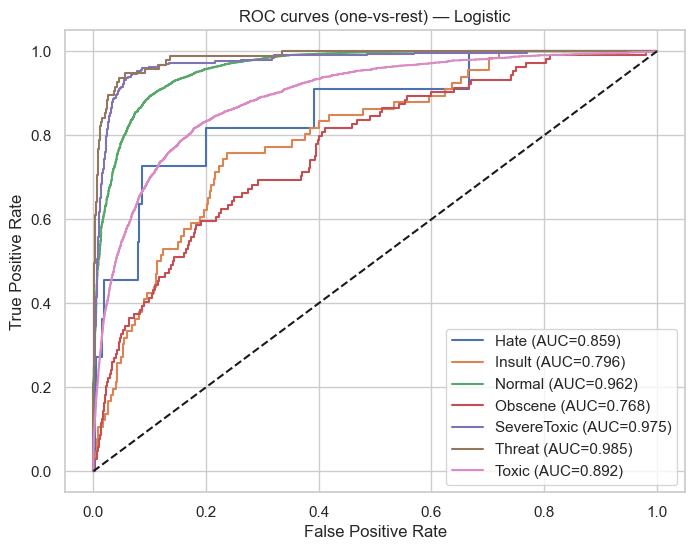


Model: RandomForest_fast
  Multiclass ROC-AUC (OVR): 0.7437


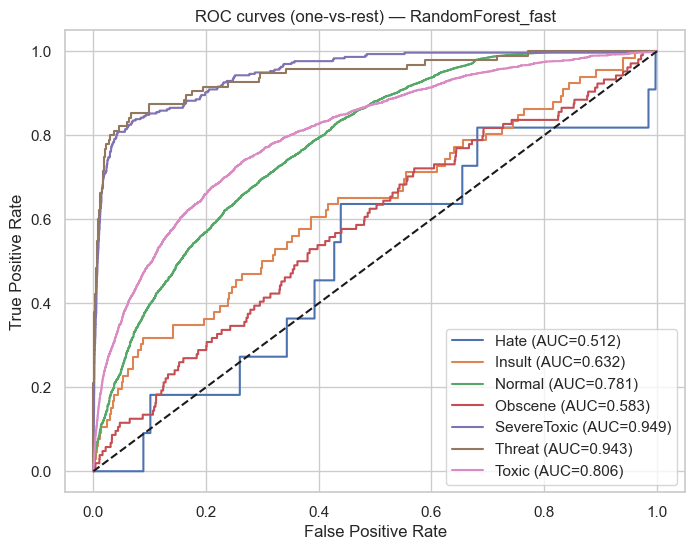


Model: svm_linear
  Multiclass ROC-AUC (OVR): 0.857


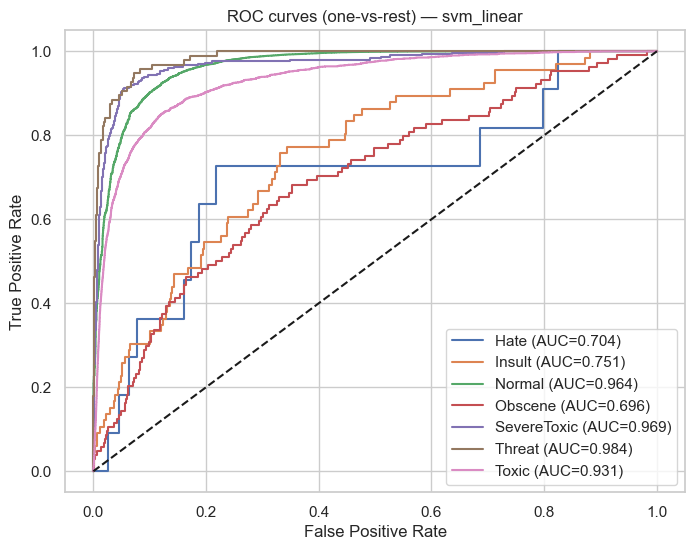

In [14]:
# Cell 11  — Classification ROC-AUC (robust: uses predict_proba or decision_function)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# classes and binarized y for multiclass one-vs-rest
classes = sorted(df_clean["label_class"].unique())
y_test_bin = label_binarize(y_test_class, classes=classes)

for name, info in clf_results.items():
    print("Model:", name)
    model = info.get("model")
    if model is None:
        print("  No model found, skipping.")
        continue

    # try to get probabilities saved earlier
    probs = info.get("probs_test", None)

    # if not present, try to compute predict_proba now
    if probs is None and hasattr(model, "predict_proba"):
        try:
            probs = model.predict_proba(X_test_final)
        except Exception as e:
            probs = None

    # if still none, try decision_function (many linear models provide this)
    scores = None
    if probs is None and hasattr(model, "decision_function"):
        try:
            df_scores = model.decision_function(X_test_final)
            # if binary (1D), convert to two-column scores
            if len(df_scores.shape) == 1:
                scores = np.vstack([-df_scores, df_scores]).T
            else:
                scores = df_scores
        except Exception as e:
            scores = None

    if probs is None and scores is None:
        print("  No predict_proba or decision_function available -> skipping AUC for this model.\n")
        continue

    y_score = probs if probs is not None else scores

    # compute multiclass (ovr) AUC
    try:
        auc_val = roc_auc_score(y_test_bin, y_score, multi_class="ovr")
        print("  Multiclass ROC-AUC (OVR):", round(auc_val, 4))
    except Exception as e:
        print("  Could not compute multiclass ROC-AUC:", e)

    # Plot ROC curves per class (one-vs-rest)
    plt.figure(figsize=(8,6))
    for i, cls in enumerate(classes):
        try:
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            auc_i = roc_auc_score(y_test_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, label=f"{cls} (AUC={auc_i:.3f})")
        except Exception as e:
            print(f"   Warning: could not compute ROC for class {cls}: {e}")
    plt.plot([0,1],[0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curves (one-vs-rest) — {name}")
    plt.legend(loc="lower right")
    plt.show()
    print()


In [15]:
# Cell 12 — Regression models: Ridge, RandomForestRegressor, GradientBoostingRegressor

# Cell 12A — Ridge Regression (baseline linear regressor)
import time, joblib
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np, os

print("Ridge Regression (linear) — using X_train_final / y_train_reg")
os.makedirs("../models", exist_ok=True)

t0 = time.time()
ridge = Ridge()
ridge.fit(X_train_final, y_train_reg)
t1 = time.time()

pred_train = ridge.predict(X_train_final)
pred_test  = ridge.predict(X_test_final)

rmse = np.sqrt(mean_squared_error(y_test_reg, pred_test))
mae  = mean_absolute_error(y_test_reg, pred_test)
r2   = r2_score(y_test_reg, pred_test)

print(f"Training time: {t1-t0:.2f}s")
print(f" Train RMSE (approx): {np.sqrt(mean_squared_error(y_train_reg, pred_train)):.3f}")
print(f" Test  RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

joblib.dump(ridge, "../models/reg_ridge.pkl")
print("Saved Ridge model -> ../models/reg_ridge.pkl")

# Store into reg_results so later cells can use it
reg_results = globals().get("reg_results", {})
reg_results["Ridge"] = {"model": ridge, "pred_train": pred_train, "pred_test": pred_test, "rmse": rmse, "r2": r2}
globals()['reg_results'] = reg_results


Ridge Regression (linear) — using X_train_final / y_train_reg
Training time: 3.66s
 Train RMSE (approx): 18.890
 Test  RMSE: 19.746, MAE: 10.001, R2: 0.686
Saved Ridge model -> ../models/reg_ridge.pkl


In [16]:
# 12B FAST FULL RandomForestRegressor Training 

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import joblib
import time

print("Training FULL RandomForestRegressor (optimized)…")

start = time.time()

# Optimized RandomForestRegressor
rf_full = RandomForestRegressor(
    n_estimators=80,        # good accuracy and fast
    max_depth=18,          # prevents overfitting
    min_samples_split=6,
    min_samples_leaf=3,
    n_jobs=-1,             # use all CPU cores
    random_state=42,
)

# Train on FULL training data
rf_full.fit(X_train_final, y_train_reg)

# Predict
pred_train = rf_full.predict(X_train_final)
pred_test  = rf_full.predict(X_test_final)

end = time.time()

print(f"Training time: {end - start:.2f} seconds")

# Metrics
rmse = np.sqrt(mean_squared_error(y_test_reg, pred_test))
mae  = mean_absolute_error(y_test_reg, pred_test)
r2   = r2_score(y_test_reg, pred_test)

print("\n--- FULL RandomForestRegressor Results ---")
print(f" Train RMSE: {np.sqrt(mean_squared_error(y_train_reg, pred_train)):.3f}")
print(f" Test  RMSE: {rmse:.3f}")
print(f" Test  MAE : {mae:.3f}")
print(f" Test  R2  : {r2:.3f}")
print("------------------------------------------")

# Save model
joblib.dump(rf_full, "../models/reg_rf_full.pkl")
print("Saved full RF model -> ../models/reg_rf_full.pkl")

# Update reg_results for later evaluation
reg_results["RandomForestReg_FULL"] = {
    "model": rf_full,
    "pred_train": pred_train,
    "pred_test": pred_test,
    "rmse": rmse,
    "r2": r2,
}

print("Updated reg_results with full RF model.")


Training FULL RandomForestRegressor (optimized)…
Training time: 838.91 seconds

--- FULL RandomForestRegressor Results ---
 Train RMSE: 19.934
 Test  RMSE: 21.880
 Test  MAE : 9.188
 Test  R2  : 0.614
------------------------------------------
Saved full RF model -> ../models/reg_rf_full.pkl
Updated reg_results with full RF model.


In [17]:
# 12C GradientBoosting (FAST_MODE True)
from sklearn.ensemble import GradientBoostingRegressor
import time, joblib, os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

FAST_MODE = True
N_EST = 100 if FAST_MODE else 200
MAX_DEPTH = 3 if FAST_MODE else 5

print(f"GradientBoostingRegressor FAST_MODE={FAST_MODE}, n_estimators={N_EST}, max_depth={MAX_DEPTH}")
os.makedirs("../models", exist_ok=True)

t0 = time.time()
gb = GradientBoostingRegressor(n_estimators=N_EST, max_depth=MAX_DEPTH, random_state=42)
gb.fit(X_train_final, y_train_reg)
t1 = time.time()

pred_train = gb.predict(X_train_final)
pred_test  = gb.predict(X_test_final)

mse = mean_squared_error(y_test_reg, pred_test)
rmse = mse**0.5
mae  = mean_absolute_error(y_test_reg, pred_test)
r2   = r2_score(y_test_reg, pred_test)

print(f"Training time: {t1-t0:.1f}s")
print(f" Test RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

joblib.dump(gb, "../models/reg_gradientboosting.pkl")
print("Saved GradientBoostingRegressor -> ../models/reg_gradientboosting.pkl")

# store to reg_results
reg_results = globals().get("reg_results", {})
reg_results["GradientBoosting"] = {"model": gb, "pred_train": pred_train, "pred_test": pred_test, "rmse": rmse, "r2": r2}
globals()['reg_results'] = reg_results


GradientBoostingRegressor FAST_MODE=True, n_estimators=100, max_depth=3
Training time: 801.7s
 Test RMSE: 21.406, MAE: 9.502, R2: 0.631
Saved GradientBoostingRegressor -> ../models/reg_gradientboosting.pkl


In [18]:
# Cell 12D (robust) — Build & train Stacking ensemble safely
import os, joblib, time, numpy as np
from pprint import pprint
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------- CONFIG ----------
# If your data is large and you want a quick test, set SAMPLE_N to an int (e.g. 20000).
# Set SAMPLE_N = None to train on full X_train_final.
SAMPLE_N = None   # None or int

# Names/filenames to look for (we try notebook variables first, then files)
WANTED = {
    "Ridge": {
        "keys": ["Ridge", "reg_ridge", "ridge"],
        "files": ["../models/reg_ridge.pkl", "../models/reg_ridge.pickle", "../models/reg_ridge"]
    },
    "RandomForest": {
        "keys": ["RandomForestReg_FULL", "RandomForestReg", "reg_rf_full", "reg_randomforest", "reg_rf_full"],
        "files": ["../models/reg_rf_full.pkl", "../models/reg_rf_full.pickle", "../models/reg_randomforest_sample.pkl", "../models/reg_rf_full"]
    },
    "GradientBoosting": {
        "keys": ["GradientBoosting", "reg_gradientboosting", "gb"],
        "files": ["../models/reg_gradientboosting.pkl", "../models/reg_gradientboosting.pickle"]
    }
}
# final estimator for stacking
META_ESTIMATOR = Ridge()    # you can change to Lasso or XGBoost if installed

# ---------- Safety checks ----------
if "X_train_final" not in globals() or "X_test_final" not in globals():
    raise NameError("X_train_final / X_test_final not found. Run feature-prep cells (TF-IDF + scaler + combine).")
if "y_train_reg" not in globals() or "y_test_reg" not in globals():
    raise NameError("y_train_reg / y_test_reg not found. Run train_test_split cell for regression targets.")

# optional quick-sample for speed
def sample_if_needed(X, y, sample_n):
    if sample_n is None:
        return X, y
    # sample indices from training set (works for sparse/dense)
    n = X.shape[0]
    idx = np.random.RandomState(42).choice(n, size=min(sample_n, n), replace=False)
    try:
        return X[idx], np.asarray(y).ravel()[idx]
    except Exception:
        # fallback: try pandas iloc if y is Series indexed by train indices
        return X[idx], np.asarray(y.iloc[idx]).ravel()

# ---------- Helper to find/load a model object ----------
def find_model_from_reg_results(key_list):
    """Try to find a model object inside reg_results (notebook memory)."""
    if "reg_results" not in globals():
        return None
    rr = globals().get("reg_results", {})
    for k in key_list:
        # exact key
        if k in rr and rr[k].get("model") is not None:
            return rr[k]["model"]
    # fuzzy key match
    for k in rr.keys():
        for want in key_list:
            if want.lower() in k.lower() or k.lower() in want.lower():
                if rr[k].get("model") is not None:
                    return rr[k]["model"]
    return None

def try_load_from_files(file_list):
    for f in file_list:
        if os.path.exists(f):
            try:
                m = joblib.load(f)
                return m
            except Exception as e:
                print(f"Found file {f} but failed to load: {e}")
    return None

# ---------- Resolve base models ----------
resolved = {}
missing = []
for nice_name, info in WANTED.items():
    model_obj = find_model_from_reg_results(info["keys"])
    if model_obj is not None:
        resolved[nice_name] = model_obj
        print(f"Found {nice_name} from reg_results.")
        continue
    # else try files
    model_obj = try_load_from_files(info["files"])
    if model_obj is not None:
        resolved[nice_name] = model_obj
        print(f"Loaded {nice_name} from file.")
        continue
    missing.append(nice_name)

if missing:
    print("\nERROR: Could not find these required base models in memory or ../models/:", missing)
    print(" - Make sure you ran/regenerated the regression models (cells 12A/12B/12C) OR that the .pkl files exist in ../models/")
    print(" - Example files to check: ../models/reg_ridge.pkl, ../models/reg_rf_full.pkl, ../models/reg_gradientboosting.pkl")
    raise RuntimeError("Missing base models: " + ", ".join(missing))

# ---------- Prepare training data (optionally sample) ----------
X_tr_used, y_tr_used = sample_if_needed(X_train_final, y_train_reg, SAMPLE_N)
X_te_used, y_te_used = X_test_final, y_test_reg

print("\nUsing training rows:", X_tr_used.shape[0])
print("Using test rows:", X_te_used.shape[0])

# ---------- Build stacking ensemble ----------
estimators = [
    ("ridge", resolved["Ridge"]),
    ("rf", resolved["RandomForest"]),
    ("gbr", resolved["GradientBoosting"])
]

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=META_ESTIMATOR,
    passthrough=True,
    n_jobs=-1,
    cv=5
)

# ---------- Train ----------
t0 = time.time()
stack.fit(X_tr_used, np.asarray(y_tr_used).ravel())
t1 = time.time()
print(f"\nTraining Ensemble Stacking Regressor... done in {t1-t0:.1f}s")

# ---------- Predict & Metrics ----------
pred_train = stack.predict(X_tr_used)
pred_test  = stack.predict(X_te_used)

mse = mean_squared_error(y_te_used, pred_test)
rmse = float(np.sqrt(mse))
mae  = float(mean_absolute_error(y_te_used, pred_test))
r2   = float(r2_score(y_te_used, pred_test))

print("\n=== Ensemble Stacking Results ===")
print(f" Train RMSE: {np.sqrt(mean_squared_error(np.asarray(y_tr_used).ravel(), pred_train)):.3f}")
print(f" Test  RMSE: {rmse:.3f}")
print(f" Test  MAE : {mae:.3f}")
print(f" Test  R2  : {r2:.3f}")

# ---------- Save ensemble and update reg_results ----------
os.makedirs("../models/final", exist_ok=True)
out_path = f"../models/final/ensemble_stacking_reg.pkl"
joblib.dump(stack, out_path)
print("Saved ensemble model ->", out_path)

# If reg_results exists, update it
rr = globals().get("reg_results", {})
rr["Ensemble_Stacking"] = {"model": stack, "pred_train": pred_train, "pred_test": pred_test, "rmse": rmse, "r2": r2}
globals()["reg_results"] = rr


Found Ridge from reg_results.
Found RandomForest from reg_results.
Found GradientBoosting from reg_results.

Using training rows: 127646
Using test rows: 31912

Training Ensemble Stacking Regressor... done in 5631.1s

=== Ensemble Stacking Results ===
 Train RMSE: 17.677
 Test  RMSE: 18.939
 Test  MAE : 8.653
 Test  R2  : 0.711
Saved ensemble model -> ../models/final/ensemble_stacking_reg.pkl

Done. You can now run your regression diagnostics cells (Cell 14) to inspect Ensemble_Stacking.


Ensemble key used: Ensemble_Stacking
 Test rows: 31912
 Test RMSE: 18.939
 Test MAE : 8.653
 Test R2  : 0.711

First 10 true vs pred:
   true        pred
0   0.0    5.273609
1   0.0   33.648248
2   0.0   13.600183
3   0.0    0.822154
4   0.0    9.081256
5   0.0    0.454833
6   0.0    4.529956
7   0.0    0.413623
8   0.0   -6.439087
9  80.0  133.382487


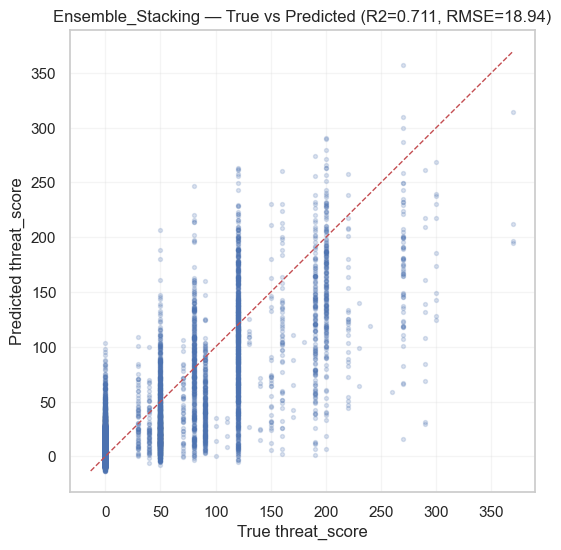

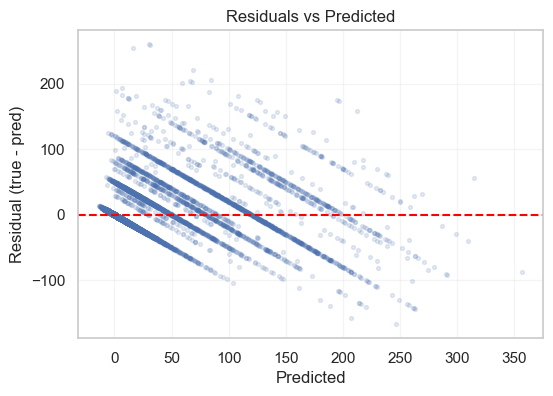

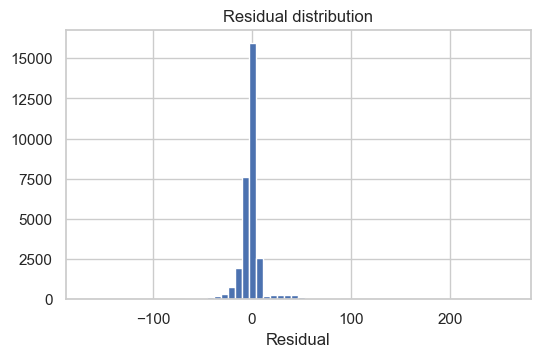

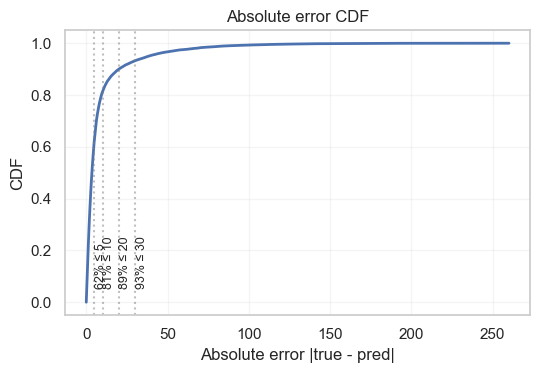


Saved ensemble path exists?: True -> ../models/final/ensemble_stacking_reg.pkl


In [19]:
# 13--------- Ensemble diagnostics & quick checks (run after training stacking) ----------
import os, joblib, numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
plt.rcParams.update({"figure.max_open_warning": 20})

# safety checks
if "reg_results" not in globals():
    raise NameError("reg_results not in globals. Run the stacking training cell first.")
if "y_test_reg" not in globals() or "X_test_final" not in globals():
    raise NameError("y_test_reg or X_test_final not found. Run feature-prep / split cells first.")

# find ensemble entry
ens_key = None
for k in reg_results.keys():
    if "Ensemble" in k or "ensemble" in k or "Stack" in k or "stack" in k:
        ens_key = k
        break
# fallback to last added reg_results key
if ens_key is None:
    ens_key = list(reg_results.keys())[-1]

info = reg_results[ens_key]
model = info.get("model", None)
pred_test = np.asarray(info.get("pred_test")) if info.get("pred_test") is not None else None

# If pred_test missing, compute from model
if pred_test is None:
    if model is None:
        raise RuntimeError(f"No model or predictions found for '{ens_key}'.")
    print("Computing predictions from model object...")
    pred_test = model.predict(X_test_final)

# metrics
y_true = np.asarray(y_test_reg).ravel()
y_pred = np.asarray(pred_test).ravel()
mse = mean_squared_error(y_true, y_pred)
rmse = mse**0.5
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Ensemble key used: {ens_key}")
print(f" Test rows: {len(y_true)}")
print(f" Test RMSE: {rmse:.3f}")
print(f" Test MAE : {mae:.3f}")
print(f" Test R2  : {r2:.3f}")

# show few predictions
print("\nFirst 10 true vs pred:")
print(pd.DataFrame({"true": y_true[:10], "pred": y_pred[:10]}))

# 1) True vs Predicted scatter
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.2, s=8)
mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
plt.xlabel("True threat_score"); plt.ylabel("Predicted threat_score")
plt.title(f"{ens_key} — True vs Predicted (R2={r2:.3f}, RMSE={rmse:.2f})")
plt.grid(alpha=0.2)
plt.show()

# 2) Residuals plot
residuals = y_true - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.15, s=8)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted"); plt.ylabel("Residual (true - pred)")
plt.title("Residuals vs Predicted")
plt.grid(alpha=0.2)
plt.show()

# 3) Histogram of residuals + CDF of absolute error
plt.figure(figsize=(6,3.5))
plt.hist(residuals, bins=60)
plt.title("Residual distribution")
plt.xlabel("Residual")
plt.show()

abs_err = np.abs(residuals)
sorted_err = np.sort(abs_err)
cdf = np.linspace(0,1,len(sorted_err))
plt.figure(figsize=(6,3.7))
plt.plot(sorted_err, cdf, linewidth=2)
for thr in (5,10,20,30):
    pct = (abs_err <= thr).sum() / len(abs_err)
    plt.axvline(thr, color='gray', linestyle=':', alpha=0.5)
    plt.text(thr+0.3, 0.05, f"{int(100*pct)}% ≤ {thr}", rotation=90, va='bottom', fontsize=9)
plt.xlabel("Absolute error |true - pred|")
plt.ylabel("CDF")
plt.title("Absolute error CDF")
plt.grid(alpha=0.2)
plt.show()

# confirm saved file
saved_path = "../models/final/ensemble_stacking_reg.pkl"
print("\nSaved ensemble path exists?:", os.path.exists(saved_path), "->", saved_path)


In [1]:
# Env fix: install optional HF helper + widgets and check GPU
import sys, subprocess, os

def pip_install(pkgs):
    cmd = [sys.executable, "-m", "pip", "install", "--quiet"] + pkgs
    print("Running:", " ".join(cmd))
    subprocess.check_call(cmd)

# try installing optional helpers (harmless if already installed)
try:
    pip_install(["huggingface_hub[hf_xet]"])
except Exception as e:
    print("Could not install hf_xet (optional):", e)

try:
    pip_install(["ipywidgets", "jupyterlab_widgets"])
except Exception as e:
    print("Could not install ipywidgets:", e)

# Silence HF symlink warning for current session
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
print("Set HF_HUB_DISABLE_SYMLINKS_WARNING=1 for session (silences symlink warning).")

# Check torch / GPU availability
try:
    import torch
    print("torch version:", torch.__version__)
    print("cuda available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU name:", torch.cuda.get_device_name(0))
        print("Allocated memory (bytes):", torch.cuda.memory_allocated(0))
        print("Reserved memory (bytes):", torch.cuda.memory_reserved(0))
except Exception as e:
    print("torch not available or failed to import:", e)


Running: D:\Sem5\INT395_SUPERVISED LEARNING\safe-text-monitor\venv\Scripts\python.exe -m pip install --quiet huggingface_hub[hf_xet]
Running: D:\Sem5\INT395_SUPERVISED LEARNING\safe-text-monitor\venv\Scripts\python.exe -m pip install --quiet ipywidgets jupyterlab_widgets
Set HF_HUB_DISABLE_SYMLINKS_WARNING=1 for session (silences symlink warning).
torch version: 2.9.1+cpu
cuda available: False


In [4]:
# Single-cell: fine-tune XLM-RoBERTa for regression with OOM-safe fallback
import math, time, os, sys
import numpy as np, pandas as pd
from datasets import Dataset, DatasetDict
import torch

# CONFIG - edit small things if needed
MODEL_NAME = "xlm-roberta-base"   # multilingual (English+Hindi)
OUTPUT_DIR = "../models/final/bert_regressor"
SAMPLE_N = None        # set to int like 10000 for quick debug, else None
num_train_epochs = 3
base_batch_size = 8    # starting point; will fallback if OOM
eval_batch_size = 16
gradient_accumulation_steps = 2  # effective batch size = base_batch_size * grad_acc_steps
learning_rate = 3e-5
seed = 42
max_length = 256

# Safety: required variables from earlier pipeline
required = ["X_train_text", "X_test_text", "y_train_reg", "y_test_reg"]
missing = [v for v in required if v not in globals()]
if missing:
    raise NameError(f"Missing variables: {missing}. Run feature-prep / train-test-split cells first.")

# Prepare dataframes
train_texts = X_train_text if SAMPLE_N is None else X_train_text.sample(n=min(SAMPLE_N, len(X_train_text)), random_state=seed)
train_idx = train_texts.index
train_targets = y_train_reg.loc[train_idx].astype(float)

train_df = pd.DataFrame({"text": train_texts.values, "label": train_targets.values})
test_df  = pd.DataFrame({"text": X_test_text.values, "label": y_test_reg.values.astype(float)})

ds = DatasetDict({"train": Dataset.from_pandas(train_df), "test": Dataset.from_pandas(test_df)})
print(f"Prepared datasets -> train rows: {len(ds['train'])}, test rows: {len(ds['test'])}")

# Import HF
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1, problem_type="regression")

# Tokenize
def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, max_length=max_length)
ds = ds.map(tokenize_batch, batched=True, remove_columns=["text"], desc="Tokenizing")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def compute_metrics_reg(eval_pred):
    preds, labels = eval_pred
    preds = np.asarray(preds).reshape(-1)
    labels = np.asarray(labels).reshape(-1)
    rmse = math.sqrt(mean_squared_error(labels, preds))
    mae = mean_absolute_error(labels, preds)
    r2 = r2_score(labels, preds)
    return {"rmse": rmse, "mae": mae, "r2": r2}

# Helper to attempt training with fallback on OOM
def train_with_fallback(base_batch_size):
    batch_size = base_batch_size
    while batch_size >= 1:
        try:
            use_fp16 = torch.cuda.is_available()
            training_args = TrainingArguments(
                output_dir=OUTPUT_DIR,
                num_train_epochs=num_train_epochs,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=min(batch_size*2, eval_batch_size),
                gradient_accumulation_steps=gradient_accumulation_steps,
                evaluation_strategy="epoch",
                save_strategy="epoch",
                learning_rate=learning_rate,
                weight_decay=0.01,
                logging_steps=200,
                save_total_limit=2,
                load_best_model_at_end=True,
                metric_for_best_model="rmse",
                greater_is_better=False,
                seed=seed,
                fp16=use_fp16,
                dataloader_num_workers=2,
            )

            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=ds["train"],
                eval_dataset=ds["test"],
                tokenizer=tokenizer,
                data_collator=data_collator,
                compute_metrics=compute_metrics_reg,
            )

            print(f"\nStarting training with per_device_train_batch_size={batch_size}, grad_accum={gradient_accumulation_steps}, fp16={use_fp16}\n")
            t0 = time.time()
            train_result = trainer.train()
            t1 = time.time()
            print(f"\nTraining finished in {(t1-t0)/60:.2f} minutes")
            # final eval
            eval_res = trainer.evaluate(ds["test"])
            print("\nFinal evaluation on test set:")
            print(f" RMSE: {eval_res.get('eval_rmse'):.3f}")
            print(f" MAE : {eval_res.get('eval_mae'):.3f}")
            print(f" R2  : {eval_res.get('eval_r2'):.3f}")
            # save explicitly
            trainer.save_model(OUTPUT_DIR)
            tokenizer.save_pretrained(OUTPUT_DIR)
            print(f"Saved trained model and tokenizer to: {OUTPUT_DIR}")
            return trainer, eval_res
        except (RuntimeError, torch.cuda.OutOfMemoryError) as e:
            print(f"OOM or runtime error with batch_size={batch_size}: {e}")
            # clear cuda cache and retry with halved batch
            try:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
            except Exception:
                pass
            batch_size = batch_size // 2
            gradient_accumulation_steps = max(1, gradient_accumulation_steps)  # keep at least 1
            print(f"Retrying with smaller batch_size={batch_size} ...")
        except Exception as e:
            print("Unexpected error during training:", e)
            raise

    raise RuntimeError("Could not train: batch size fell below 1.")

# Run training (with fallback)
trainer, eval_metrics = train_with_fallback(base_batch_size)


NameError: Missing variables: ['X_train_text', 'X_test_text', 'y_train_reg', 'y_test_reg']. Run feature-prep / train-test-split cells first.

In [ ]:
# Cell 13 A — Inspect what's in memory and on-disk
import os, glob, joblib, numpy as np, pandas as pd
from pprint import pprint

print("Working dir:", os.getcwd())
print()

# Check core variables needed
needed = ["X_test_final", "y_test_class", "X_train_final", "y_train_class"]
for n in needed:
    print(n, "in globals() ->", n in globals())

print("\nExisting 'clf_results' keys (if present):")
cr = globals().get("clf_results", {})
print(list(cr.keys()))

print("\nModel files in ../models/:")
for p in sorted(glob.glob("../models/*.pkl")):
    print(" -", os.path.basename(p))

# show a couple of common variable names that may contain models/pred arrays
cand = ["log_model","pred_test_lr","pred_test","pred_test_lr","pred_test_rf","pred_test_svm",
        "rf_model","svm_model","svm_linear","logistic_baseline","rf_config_fast","svm_any"]
found = {k: type(globals()[k]).__name__ if k in globals() else None for k in cand}
print("\nCommon training variable check:")
pprint(found)



In [57]:
# Cell 13 B — Ensure clf_results contains only the three intended classifiers
import numpy as np, joblib, glob, os

# names you trained (edit if your keys differ)
WANTED = ["Logistic", "RandomForest", "svm_linear"]

# safety checks
if 'clf_results' not in globals():
    raise NameError("clf_results not found in globals(). Run the training cells (10A/10B/10C) first.")

test_len = len(y_test_class) if 'y_test_class' in globals() else None
if test_len is None:
    raise NameError("y_test_class not in globals(). Re-run the train/test-split cells.")

print("Starting clf_results cleanup — expected test length:", test_len)

new = {}
skipped = []
for want in WANTED:
    # find best matching key in clf_results (case-insensitive / fuzzy)
    found_key = None
    for k in list(clf_results.keys()):
        if k.lower() == want.lower() or want.lower() in k.lower() or k.lower() in want.lower():
            found_key = k
            break
    if not found_key:
        skipped.append((want, "not found in clf_results"))
        continue

    info = clf_results[found_key]
    pred = info.get("pred_test", None)
    model_obj = info.get("model", None)

    # if pred missing or wrong length, try recompute
    if pred is None or len(np.asarray(pred).ravel()) != test_len:
        if model_obj is not None:
            try:
                preds = np.asarray(model_obj.predict(X_test_final)).ravel()
                if len(preds) == test_len:
                    info['pred_test'] = preds
                    # try predict_proba if available
                    try:
                        info['probs_test'] = model_obj.predict_proba(X_test_final)
                    except Exception:
                        info['probs_test'] = info.get('probs_test', None)
                    print(f"Recomputed preds for '{found_key}' from model object.")
                else:
                    skipped.append((found_key, f"recomputed preds length {len(preds)} != {test_len}"))
                    continue
            except Exception as e:
                skipped.append((found_key, f"model.predict failed: {e}"))
                continue
        else:
            skipped.append((found_key, "no pred_test and no model object"))
            continue

    # final length check
    pred = np.asarray(info['pred_test']).ravel()
    if len(pred) == test_len:
        new_label = want  # keep user-intended name
        new[new_label] = {"model": info.get("model", None),
                          "pred_test": pred,
                          "pred_train": info.get("pred_train", None),
                          "probs_test": info.get("probs_test", None)}
        print(f"Kept: {new_label}")
    else:
        skipped.append((found_key, f"final pred length {len(pred)} != {test_len}"))

# overwrite global clf_results
globals()['clf_results'] = new

print("\nCleanup done. Kept keys:", list(new.keys()))
if skipped:
    print("\nSkipped items (reasons):")
    for s in skipped:
        print(" -", s[0], ":", s[1])

# quick sanity check
for k,v in globals()['clf_results'].items():
    print(k, "-> pred_test length:", len(v['pred_test']), "probs:", v['probs_test'] is not None)


Starting clf_results cleanup — expected test length: 31912
Kept: Logistic
Kept: RandomForest
Kept: svm_linear

Cleanup done. Kept keys: ['Logistic', 'RandomForest', 'svm_linear']
Logistic -> pred_test length: 31912 probs: False
RandomForest -> pred_test length: 31912 probs: True
svm_linear -> pred_test length: 31912 probs: False


In [ ]:
# Cell 13 — Classification summary + confusion matrix (ready-to-run)
# Cell C — Classification summary + confusion matrix (clean)
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

sns.set(style="whitegrid")

# safety
if 'clf_results' not in globals():
    raise NameError("clf_results not found. Run Cell B first.")
if 'y_test_class' not in globals():
    raise NameError("y_test_class not in globals(). Re-run feature-prep split cells.")

test_len = len(y_test_class)

rows = []
for name, info in clf_results.items():
    pred = np.asarray(info.get("pred_test", None)).ravel()
    if pred is None or len(pred) != test_len:
        print(f"Skipping {name}: invalid predictions")
        continue
    rows.append({
        "model": name,
        "accuracy": accuracy_score(y_test_class, pred),
        "precision_weighted": precision_score(y_test_class, pred, average="weighted", zero_division=0),
        "recall_weighted": recall_score(y_test_class, pred, average="weighted", zero_division=0),
        "f1_weighted": f1_score(y_test_class, pred, average="weighted", zero_division=0)
    })

if not rows:
    raise RuntimeError("No valid classifier results to summarize.")

summary_clf = pd.DataFrame(rows).sort_values("f1_weighted", ascending=False).reset_index(drop=True)
display(summary_clf)

best_clf_name = summary_clf.loc[0, "model"]
print("Best classifier by weighted F1:", best_clf_name)

# confusion matrix for best
best_pred = np.asarray(clf_results[best_clf_name]["pred_test"]).ravel()
labels = sorted(df_clean["label_class"].unique()) if ('df_clean' in globals() and "label_class" in df_clean.columns) else sorted(np.unique(y_test_class))

cm = confusion_matrix(y_test_class, best_pred, labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(f"Confusion Matrix — {best_clf_name}")
plt.tight_layout()
plt.show()
# Optional: print a small per-class summary (support counts)
support_counts = pd.Series(y_test_class).value_counts().reindex(labels).fillna(0).astype(int)
print("\nSupport (test set counts) per class:")
print(support_counts.to_string())



In [ ]:
# Cell 14 — Regression summary + best regressor plot (keep only desired regressors)
import numpy as np, pandas as pd, matplotlib.pyplot as plt, joblib, os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# names of regressors you implemented (edit if different)
WANTED_REG = ["Ridge", "RandomForestReg_FULL", "GradientBoosting"]

# safety
if 'reg_results' not in globals():
    raise NameError("reg_results not found. Run regression training cells (12A/12B/12C) first.")
if 'y_test_reg' not in globals():
    raise NameError("y_test_reg not found. Re-run split/feature-prep cells.")

n_test = len(y_test_reg)
print("Regression test size:", n_test)

# filter reg_results to wanted keys (fuzzy match)
filtered = {}
for want in WANTED_REG:
    found = None
    for k in reg_results.keys():
        if k.lower() == want.lower() or want.lower() in k.lower() or k.lower() in want.lower():
            found = k; break
    if not found:
        print(f"Warning: regressor '{want}' not found in reg_results (check names).")
        continue

    info = reg_results[found]
    pred = info.get("pred_test", None)
    model_obj = info.get("model", None)
    # try to recompute if missing/wrong length
    if pred is None or len(np.asarray(pred).ravel()) != n_test:
        if model_obj is not None:
            try:
                pred = np.asarray(model_obj.predict(X_test_final)).ravel()
                info['pred_test'] = pred
                print(f"Recomputed preds for {found}")
            except Exception as e:
                print(f"Could not recompute preds for {found}: {e}")
                continue
        else:
            print(f"No preds & no model object for {found}")
            continue

    if len(np.asarray(info['pred_test']).ravel()) == n_test:
        filtered[found] = info

if not filtered:
    raise RuntimeError("No regressors found after filtering. Check names or recompute predictions.")

# compute metrics
rows = []
for k,info in filtered.items():
    y_pred = np.asarray(info['pred_test']).ravel()
    y_true = np.asarray(y_test_reg).ravel()
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    rows.append({"model": k, "RMSE": rmse, "MAE": mae, "R2": r2})
    # update reg_results entries
    filtered[k].update({"rmse": rmse, "mae": mae, "r2": r2})

reg_summary = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
print("\n=== Regressor summary (sorted by RMSE) ===")
display(reg_summary)

best_reg_name = reg_summary.loc[0, "model"]
print("Best regressor by RMSE:", best_reg_name)

# plot true vs predicted for best regressor
y_true = np.asarray(y_test_reg).ravel()
y_pred_best = np.asarray(filtered[best_reg_name]['pred_test']).ravel()

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_best, alpha=0.25, s=8)
mn, mx = min(y_true.min(), y_pred_best.min()), max(y_true.max(), y_pred_best.max())
plt.plot([mn,mx],[mn,mx],"r--")
plt.xlabel("True threat_score"); plt.ylabel("Predicted threat_score")
plt.title(f"True vs Predicted — {best_reg_name}\nRMSE={filtered[best_reg_name]['rmse']:.3f}, R2={filtered[best_reg_name]['r2']:.3f}")
plt.show()

# save best regressor (optional)
os.makedirs("../models/final", exist_ok=True)
best_obj = filtered[best_reg_name].get("model", None)
if best_obj is not None:
    joblib.dump(best_obj, f"../models/final/{best_reg_name}_final_reg.pkl")
    print("Saved best regressor to ../models/final/")


In [64]:
# Cell 15 — Save final models & transformers (canonical files)
import os, joblib

os.makedirs("../models/final", exist_ok=True)

# names you reported earlier — adjust if your variable names differ
# Classification: choose the best classifier variable/object name in memory.
# From your results it looked like svm_linear (or svm_linear_final saved file) was best.
# Regression: Ridge (you saved Ridge_final_reg.pkl earlier)
# Transformers: tfidf and scaler

# Try to grab in-memory objects; if not present, fallback to loading from models
def safe_save(obj_name, src_obj=None, fallback_file=None, dest_name=None):
    if dest_name is None:
        dest_name = obj_name + ".pkl"
    dest_path = os.path.join("../models/final", dest_name)
    if src_obj is not None:
        joblib.dump(src_obj, dest_path)
        print(f"Saved {obj_name} from memory -> {dest_path}")
        return
    if fallback_file and os.path.exists(fallback_file):
        # load and re-save canonical
        m = joblib.load(fallback_file)
        joblib.dump(m, dest_path)
        print(f"Loaded {fallback_file} and saved as canonical -> {dest_path}")
        return
    print(f"Warning: {obj_name} not found and no fallback file provided.")

# Example names — change if your variables differ:
# classifier object(s)
safe_save("svm_linear_final",
          src_obj=globals().get("svm_model") or globals().get("svm_linear") or globals().get("svm_any"),
          fallback_file="../models/svm_linear.pkl",
          dest_name="svm_linear_final.pkl")

safe_save("logistic_final",
          src_obj=globals().get("log_model") or globals().get("logistic_baseline"),
          fallback_file="../models/logistic_baseline.pkl",
          dest_name="logistic_final.pkl")

safe_save("rf_final",
          src_obj=globals().get("rf_model") or globals().get("rf"),
          fallback_file="../models/rf_config_fast.pkl",
          dest_name="rf_final.pkl")

# regression final
safe_save("ridge_final",
          src_obj=globals().get("ridge"),
          fallback_file="../models/reg_ridge.pkl",
          dest_name="Ridge_final_reg.pkl")

# transformers
safe_save("tfidf", src_obj=globals().get("tfidf"), fallback_file="../models/tfidf.pkl", dest_name="tfidf_final.pkl")
safe_save("scaler", src_obj=globals().get("scaler"), fallback_file="../models/scaler.pkl", dest_name="scaler_final.pkl")

print("Done. Check ../models/final/ to confirm files.")


Saved svm_linear_final from memory -> ../models/final\svm_linear_final.pkl
Saved logistic_final from memory -> ../models/final\logistic_final.pkl
Saved rf_final from memory -> ../models/final\rf_final.pkl
Saved ridge_final from memory -> ../models/final\Ridge_final_reg.pkl
Saved tfidf from memory -> ../models/final\tfidf_final.pkl
Saved scaler from memory -> ../models/final\scaler_final.pkl
Done. Check ../models/final/ to confirm files.


In [ ]:
import os, shutil
os.makedirs("../models/archive", exist_ok=True)
shutil.make_archive("../models/archive/models_backup", 'zip', "../models")
print("Backup created: ../models/archive/models_backup.zip")


In [ ]:
import glob, pprint
files = sorted(glob.glob("../models/*.pkl") + glob.glob("../models/final/*.pkl"))
pprint.pprint(files)


In [67]:
# DEBUG CELL — paste and run (Ctrl+Enter)
import sys, os, traceback
from pathlib import Path
import glob

print("1) Kernel alive? Python version:", sys.version.splitlines()[0])
print("2) Notebook working dir:", Path.cwd())
print()

# list top-level files and some dirs
def list_dir(p):
    try:
        items = sorted(Path(p).iterdir())
        print(f"Contents of {p}: ({len(items)} items)")
        for i, it in enumerate(items[:30]):
            print(f"  {i+1:2d}. {it.name} {'(dir)' if it.is_dir() else ''}")
        if len(items) > 30:
            print("  ... (more files omitted)")
    except Exception as e:
        print(f"  Could not list {p}: {e}")

list_dir(".")
print()
list_dir("../data")
print()
list_dir("../data/raw")
print()
list_dir("../models")
print()
list_dir("../models/final")
print()

# check specific file path used in your notebook
raw_path = Path("../data/raw/train.csv")
print("Does ../data/raw/train.csv exist? ->", raw_path.exists())
if raw_path.exists():
    try:
        size = raw_path.stat().st_size
        print(" Size (bytes):", size)
        print(" First 3 lines of the file (raw):")
        with raw_path.open("r", encoding="utf-8", errors="replace") as f:
            for i in range(3):
                line = f.readline()
                if not line:
                    break
                print(f"  L{i+1}: {line.strip()[:250]}")
    except Exception as e:
        print("  Could not read file:", e)
else:
    print("  File missing — double-check you placed train.csv at ../data/raw/train.csv relative to the notebook.")

# Try loading with pandas and print a small head (catch exceptions and print trace)
print("\nAttempting to load CSV with pandas (this may take a moment if file is big)...")
try:
    import pandas as pd
    df = pd.read_csv(raw_path, nrows=5)
    print("Loaded head (first 5 rows):")
    display(df)
    print("OK: pandas read succeeded for nrows=5.")
except Exception as e:
    print("Error loading CSV with pandas:")
    traceback.print_exc()


1) Kernel alive? Python version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
2) Notebook working dir: D:\Sem5\INT395_SUPERVISED LEARNING\safe-text-monitor\notebooks

Contents of .: (3 items)
   1. .ipynb_checkpoints (dir)
   2. 01_tfidf_baseline.ipynb 
   3. 02_full_pipeline.ipynb 

Contents of ../data: (4 items)
   1. processed (dir)
   2. raw (dir)
   3. sample (dir)
   4. sample_messages.csv 

Contents of ../data/raw: (1 items)
   1. train.csv 

Contents of ../models: (15 items)
   1. archive (dir)
   2. classifier.pkl 
   3. final (dir)
   4. logistic_baseline.pkl 
   5. reg_gradientboosting.pkl 
   6. reg_randomforest_sample.pkl 
   7. reg_rf_full.pkl 
   8. reg_ridge.pkl 
   9. regressor.pkl 
  10. rf_config_fast.pkl 
  11. scaler.pkl 
  12. scaler_sample_for_rf.pkl 
  13. svm_linear.pkl 
  14. tfidf.pkl 
  15. tfidf_sample_for_rf.pkl 

Contents of ../models/final: (6 items)
   1. logistic_final.pkl 
   2. rf_final.pkl 
   3. Ridge_final_reg.p

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


OK: pandas read succeeded for nrows=5.
